In [781]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import csv
from numba import jit
%matplotlib inline

### Data Ingestion

In [6]:
input_path = 'Train/'

In [7]:
def load_df(path):    
    def get_filename(image_id):
        return os.path.join(input_path, image_id + ".jpeg")

    df_node = pd.read_csv(path)
    df_node["file"] = df_node["image"].apply(get_filename)
    df_node = df_node.dropna()
    
    return df_node

df = load_df(os.path.join(input_path, "trainLabels.csv"))
len(df)

df.head()

image  level                 file
0   10_left      0   Train/10_left.jpeg
1  10_right      0  Train/10_right.jpeg
2   13_left      0   Train/13_left.jpeg
3  13_right      0  Train/13_right.jpeg
4   15_left      1   Train/15_left.jpeg

In [45]:
filtered = pd.Series(data = [os.path.splitext(x)[0] for x in os.listdir('Train')])

In [50]:
df = df[df.image.isin(filtered.values)]

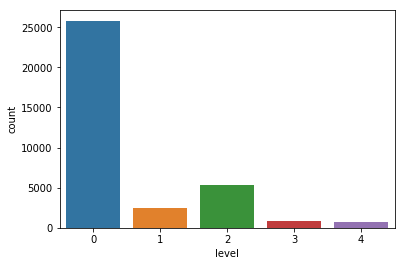

In [9]:
ax = sns.countplot(df.level)

There is class imabalance present

0 - 4 depicts the scale of the severeness of the DR

In [51]:
import math

def get_filelist(level=0):
    return df[df['level'] == level]['file'].values

def subplots(filelist):
    plt.figure(figsize=(16, 12))
    ncol = 3
    nrow = math.ceil(len(filelist) // ncol)
    
    for i in range(0, len(filelist)):
        print(i,filelist[i])
        plt.subplot(nrow, ncol, i + 1)
        img = cv2.imread(filelist[i])
        plt.imshow(img)

In [52]:
filelist = get_filelist(level=0)[:9]

In [53]:
filelist

array(['Train/10_left.jpeg', 'Train/10_right.jpeg', 'Train/13_left.jpeg',
       'Train/13_right.jpeg', 'Train/17_left.jpeg', 'Train/100_left.jpeg',
       'Train/100_right.jpeg', 'Train/102_left.jpeg',
       'Train/102_right.jpeg'], dtype=object)

0 Train/10_left.jpeg
1 Train/10_right.jpeg
2 Train/13_left.jpeg
3 Train/13_right.jpeg
4 Train/17_left.jpeg
5 Train/100_left.jpeg
6 Train/100_right.jpeg
7 Train/102_left.jpeg
8 Train/102_right.jpeg


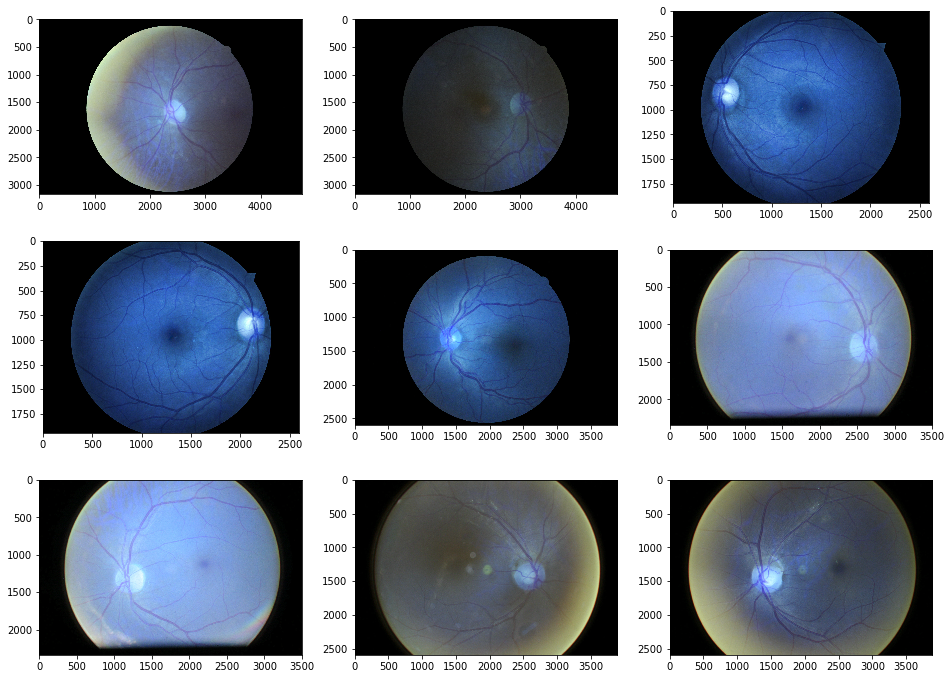

In [54]:
subplots(filelist)

0 Train/15_left.jpeg
1 Train/17_right.jpeg
2 Train/114_left.jpeg
3 Train/114_right.jpeg
4 Train/178_left.jpeg
5 Train/178_right.jpeg
6 Train/1020_left.jpeg
7 Train/1020_right.jpeg
8 Train/1027_left.jpeg


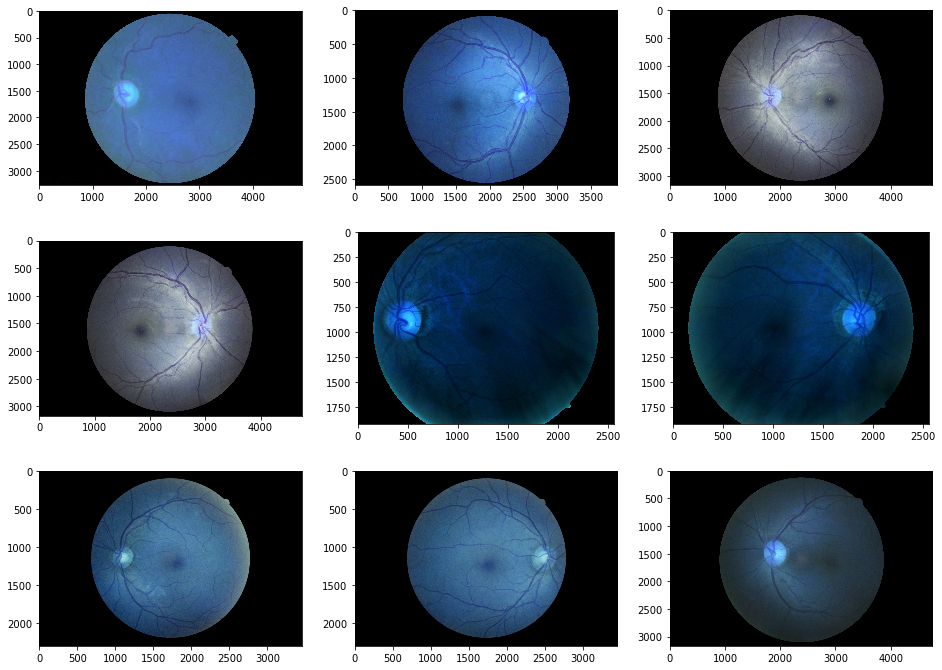

In [56]:
# Plotting Sev 1 
filelist = get_filelist(level=1)[:9]
subplots(filelist)

0 Train/15_right.jpeg
1 Train/129_left.jpeg
2 Train/129_right.jpeg
3 Train/155_right.jpeg
4 Train/172_left.jpeg
5 Train/172_right.jpeg
6 Train/184_left.jpeg
7 Train/184_right.jpeg
8 Train/192_left.jpeg


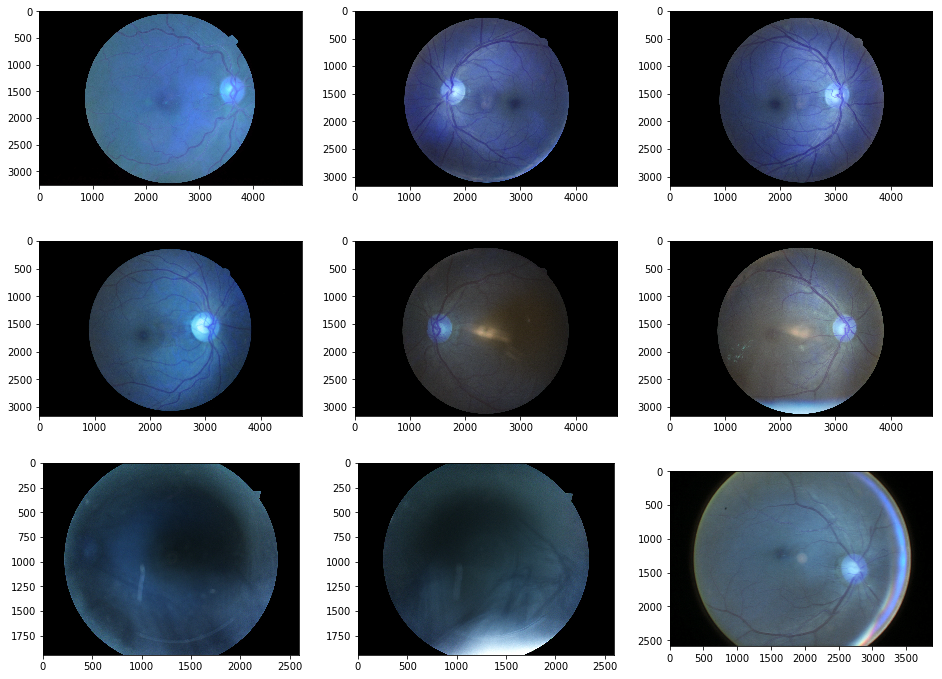

In [57]:
# Plotting Sev 2
filelist = get_filelist(level=2)[:9]
subplots(filelist)

0 Train/163_left.jpeg
1 Train/163_right.jpeg
2 Train/1002_left.jpeg
3 Train/1008_left.jpeg
4 Train/1008_right.jpeg
5 Train/1099_left.jpeg
6 Train/1162_left.jpeg
7 Train/1162_right.jpeg
8 Train/1177_left.jpeg


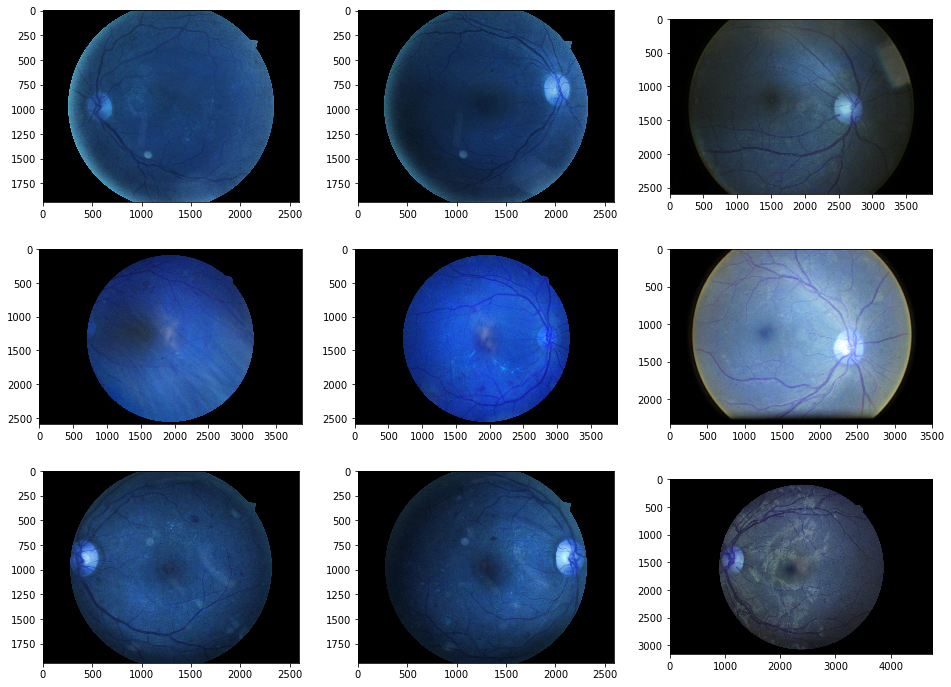

In [58]:
# Plotting Sev 3
filelist = get_filelist(level=3)[:9]
subplots(filelist)

0 Train/16_left.jpeg
1 Train/16_right.jpeg
2 Train/1084_left.jpeg
3 Train/1084_right.jpeg
4 Train/1099_right.jpeg
5 Train/1138_left.jpeg
6 Train/1138_right.jpeg
7 Train/1350_left.jpeg
8 Train/1430_left.jpeg


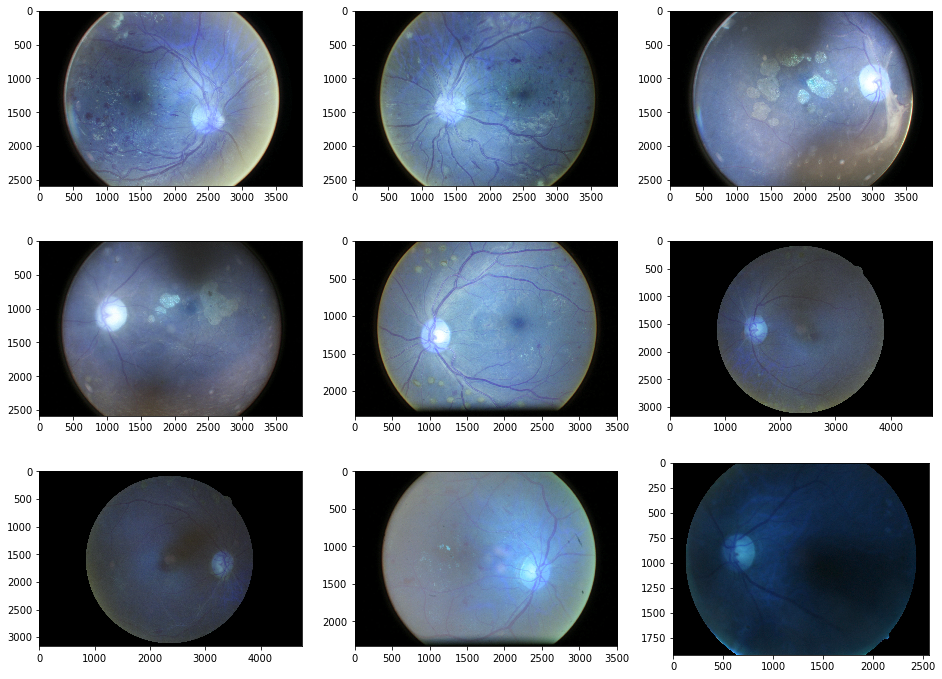

In [59]:
# Plotting Sev 1 
filelist = get_filelist(level=4)[:9]
subplots(filelist)

### Preprocessing

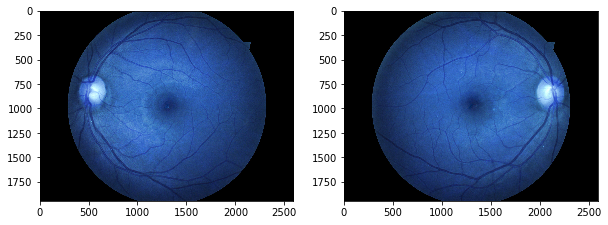

In [258]:
# We will take 2 images 1 of no retinopathy and 2 having severe retinopathy to see the preprocessing effect
img_negative_left = cv2.imread('Train/13_left.jpeg')
img_negative_right = cv2.imread('Train/13_right.jpeg')
fig,ax = plt.subplots(nrows=1,ncols=2,figsize = (10,10))
ax[0].imshow(img_negative_left)
ax[1].imshow(img_negative_right)

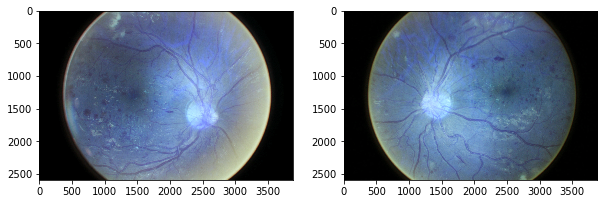

In [259]:
img_positive_left = cv2.imread('Train/16_left.jpeg')
img_positive_right = cv2.imread('Train/16_right.jpeg')
fig,ax = plt.subplots(nrows=1,ncols=2, figsize = (10,10))
ax[0].imshow(img_positive_left)
ax[1].imshow(img_positive_right)

#### Cropping and resizing so as to later preprocess

In [262]:
def display_side_by_side(img1,img2,cmap = 'gray'):
    fig,ax = plt.subplots(nrows=1,ncols=2, figsize = (10,10))
    ax[0].imshow(img1,cmap = cmap)
    ax[1].imshow(img2, cmap = cmap)

In [248]:
# Resize image as per fixed radius
def scaleRadius(img,scale = 256):
    x = img[img.shape[0] // 2 , : , : ].sum(1)
    r=(x>x.mean()/10).sum()/2
    s=scale * 1.0/ r
    return cv2.resize(img,(0,0),fx = s,fy = s)

In [266]:
#remove black edges
def crop_image(img,tol=0):
    # img is image data
    # tol  is tolerance
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

#### Preprocessing
1. Conversion to grayscale
2. Subtracting local mean average color to get a clear picture of nerve endings

In [275]:
def subtract_gaussian_blur(img):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img = crop_image(img)
    gb_img = cv2.GaussianBlur(img, (0, 0), 5) 
    return cv2.addWeighted(img, 4, gb_img, -4, 128)

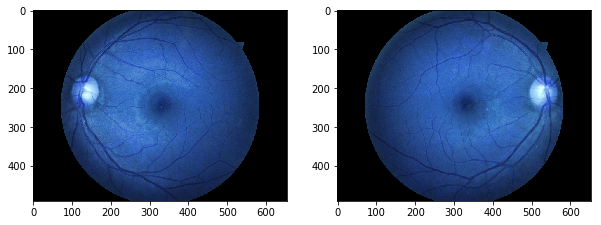

In [276]:
img_negative_left_cropped  = scaleRadius(img_negative_left)
img_negative_right_cropped = scaleRadius(img_negative_right)
display_side_by_side(img_negative_left_cropped,img_negative_right_cropped)

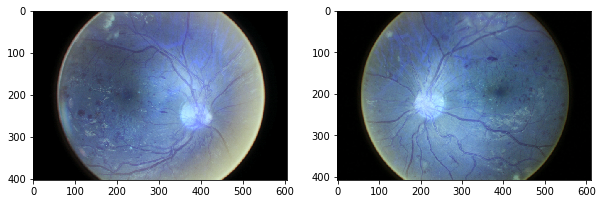

In [277]:
img_positive_left_cropped  = scaleRadius(img_positive_left)
img_positive_right_cropped = scaleRadius(img_positive_right)
display_side_by_side(img_positive_left_cropped,img_positive_right_cropped)

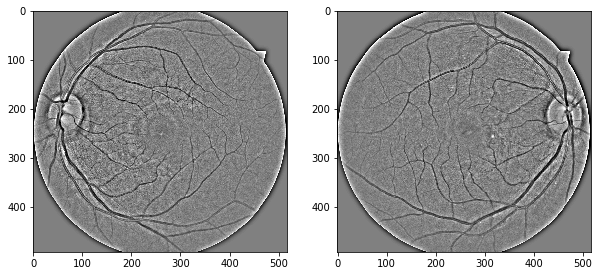

In [278]:
img_negative_left_cropped = subtract_gaussian_blur(img_negative_left_cropped)
img_negative_right_cropped = subtract_gaussian_blur(img_negative_right_cropped)
display_side_by_side(img_negative_left_cropped,img_negative_right_cropped)

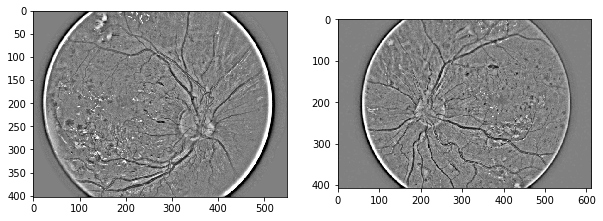

In [279]:
img_positive_left_cropped = subtract_gaussian_blur(img_positive_left_cropped)
img_positive_right_cropped = subtract_gaussian_blur(img_positive_right_cropped)
display_side_by_side(img_positive_left_cropped,img_positive_right_cropped)

3. Due to intensity variation, we are not able to distinguish between veins and other eye features.We then try applying histogram equlization (Adaptive equalization) to be able to distinguish 

In [325]:
def apply_hist_norm(img):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl1 = clahe.apply(img_positive_left_cropped)
    return cl1

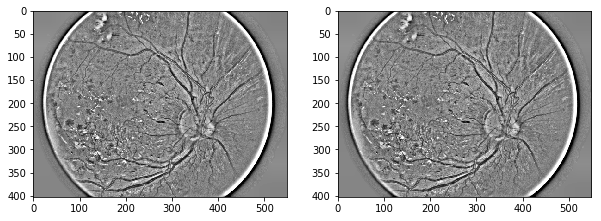

In [326]:
img_negative_left_eq = apply_hist_norm(img_negative_left_cropped)
img_negative_right_eq = apply_hist_norm(img_negative_right_cropped)
display_side_by_side(img_negative_left_eq,img_negative_right_eq)

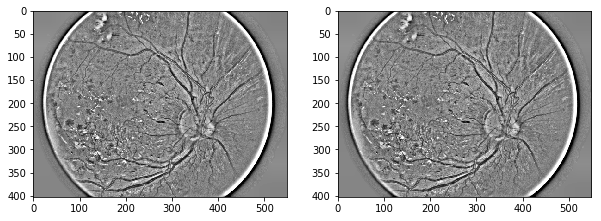

In [327]:
img_positive_left_eq = apply_hist_norm(img_positive_left_cropped)
img_positive_right_eq = apply_hist_norm(img_positive_right_cropped)
display_side_by_side(img_positive_left_eq,img_positive_right_eq)

### Feature Extraction

Any image problem (segmentation/classification/object detection) can be solved using 3 approaches
1. Legacy approach using Legacy Image processing algorithm (like Watershed Algorithm)
2. Extracting specific features of the image and then feeding it into a ML algorithm (like SVM)
3. Basic preprocessing and feeding the image into a Deep NN (eg - CNN). Here feature extraction is done automatically by the hidden layers of the network

In this kernel we will demonstrate feature extraction of few features. The extraction of features is done by segmenting the image and extracting useful parts of the image that can have casual impact on the outcome i.e DR. The extracted features can also help opthamologists to analyze specific parts of the scan

#### Blood Vessel Segmentation

In [479]:
def segment_blood_vessel_grayscale(img):
    # Apply alternate Sequential Filtering
    r1 = cv2.morphologyEx(img_negative_left_cropped, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)), iterations = 1)
    R1 = cv2.morphologyEx(r1, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)), iterations = 1)
    r2 = cv2.morphologyEx(R1, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11)), iterations = 1)
    R2 = cv2.morphologyEx(r2, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11)), iterations = 1)
    r3 = cv2.morphologyEx(R2, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(23,23)), iterations = 1)
    R3 = cv2.morphologyEx(r3, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(23,23)), iterations = 1)
    f4 = cv2.subtract(R3,img_negative_left_cropped)
    
    # removing very small contours through area parameter noise removal
    _,f6 = cv2.threshold(f4,15,255,cv2.THRESH_BINARY)
    mask = np.ones(f4.shape[:2], dtype="uint8") * 255
    im2, contours, hierarchy = cv2.findContours(f6.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_NONE)
    for cnt in contours:
        if cv2.contourArea(cnt) <= 0.5:
            cv2.drawContours(mask, [cnt], -1, 0, -1)
    im = cv2.bitwise_and(f4, f4, mask=mask)
    ret,fin = cv2.threshold(im,15,255,cv2.THRESH_BINARY_INV)
    newfin = cv2.erode(fin, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(2,2)), iterations=1)
    
    # removing blobs of unwanted bigger chunks taking in consideration they are not straight lines like blood
    #vessels and also in an interval of area
    fundus_eroded = cv2.bitwise_not(newfin)
    xmask = np.ones(fundus_eroded.shape[:2], dtype="uint8") * 255
    x1, xcontours, xhierarchy = cv2.findContours(fundus_eroded.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    for cnt in xcontours:
        shape = "unidentified"
        peri = cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, 0.04 * peri, False)
        if len(approx) > 4 and cv2.contourArea(cnt) <= 20 and cv2.contourArea(cnt) >= 2:
            shape = "circle"
        else:
            shape = "veins"
        if(shape=="circle"):
            cv2.drawContours(xmask, [cnt], -1, 0, -1)
    #plt.imshow(xmask,cmap='gray')
    finimage = cv2.bitwise_and(fundus_eroded,fundus_eroded,mask=xmask)
    blood_vessels = cv2.bitwise_not(finimage)
    return blood_vessels

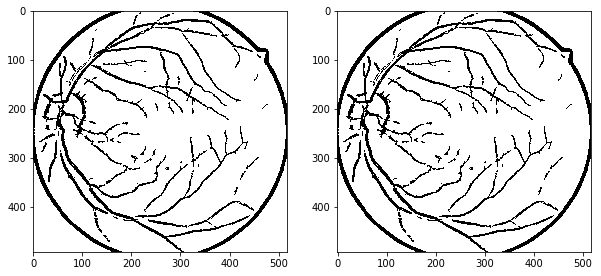

In [480]:
img_negative_left_bv = segment_blood_vessel_grayscale(img_negative_left_cropped)
img_negative_right_bv = segment_blood_vessel_grayscale(img_negative_right_cropped)
display_side_by_side(img_negative_left_bv,img_negative_right_bv)

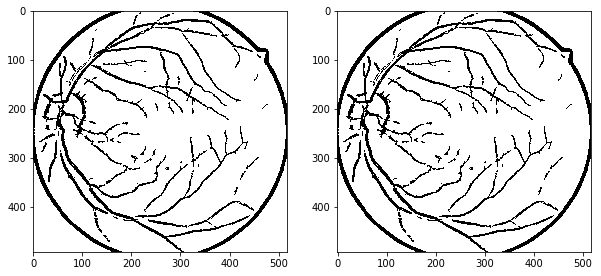

In [482]:
img_positive_left_bv = segment_blood_vessel_grayscale(img_positive_left_cropped)
img_positive_right_bv = segment_blood_vessel_grayscale(img_positive_right_cropped)
display_side_by_side(img_positive_left_bv,img_positive_right_bv)

**Steps taken**
1. First we apply Alternate Sequential Filtering which is type of morphological operation. We apply different sized element kernel closing and opening operation. This has an effect of smoothing the image without loosing over the significant parts of the image. The o/p is then subtracted from the base image, which produces a skeleton of nerves thereby removing the noise
2. We still have other small objects present like blood vessels and other parts, We then filter this by contour detection. We first find all the contours of the image and then filter the necessary contours. Then the subset is plotted to a separate mask which is later applied to image to remove the unnecessary part. This is done using bitwise operators

In [485]:
# Alternate method to segment with channel image
def segment_blood_vessel_channel(image):
    b,green_fundus,r = cv2.split(image)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    contrast_enhanced_green_fundus = clahe.apply(green_fundus)

    # applying alternate sequential filtering (3 times closing opening)
    r1 = cv2.morphologyEx(contrast_enhanced_green_fundus, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)), iterations = 1)
    R1 = cv2.morphologyEx(r1, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)), iterations = 1)
    r2 = cv2.morphologyEx(R1, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11)), iterations = 1)
    R2 = cv2.morphologyEx(r2, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11)), iterations = 1)
    r3 = cv2.morphologyEx(R2, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(23,23)), iterations = 1)
    R3 = cv2.morphologyEx(r3, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(23,23)), iterations = 1)
    f4 = cv2.subtract(R3,contrast_enhanced_green_fundus)
    f5 = clahe.apply(f4)
    
    # removing very small contours through area parameter noise removal
    ret,f6 = cv2.threshold(f5,15,255,cv2.THRESH_BINARY)
    mask = np.ones(f5.shape[:2], dtype="uint8") * 255
    im2, contours, hierarchy = cv2.findContours(f6.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        if cv2.contourArea(cnt) <= 200:
            cv2.drawContours(mask, [cnt], -1, 0, -1)
    #plt.imshow(mask,cmap='gray')
    im = cv2.bitwise_and(f5, f5, mask=mask)
    #plt.imshow(im,cmap='gray')
    ret,fin = cv2.threshold(im,15,255,cv2.THRESH_BINARY_INV)
    #plt.imshow(fin,cmap = 'gray')
    newfin = cv2.erode(fin, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)), iterations=1)
    #plt.imshow(newfin,cmap = 'gray')
    

    # removing blobs of unwanted bigger chunks taking in consideration they are not straight lines like blood
    #vessels and also in an interval of area
    fundus_eroded = cv2.bitwise_not(newfin)
    xmask = np.ones(fundus_eroded.shape[:2], dtype="uint8") * 255
    x1, xcontours, xhierarchy = cv2.findContours(fundus_eroded.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    for cnt in xcontours:
        shape = "unidentified"
        peri = cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, 0.04 * peri, False)
        if len(approx) > 4 and cv2.contourArea(cnt) <= 3000 and cv2.contourArea(cnt) >= 100:
            shape = "circle"
        else:
            shape = "veins"
        if(shape=="circle"):
            cv2.drawContours(xmask, [cnt], -1, 0, -1)
    #plt.imshow(fundus_eroded,cmap = 'gray')

    finimage = cv2.bitwise_and(fundus_eroded,fundus_eroded,mask=xmask)
    blood_vessels = cv2.bitwise_not(finimage)
    #plt.imshow(finimage,cmap='gray')
    return blood_vessels

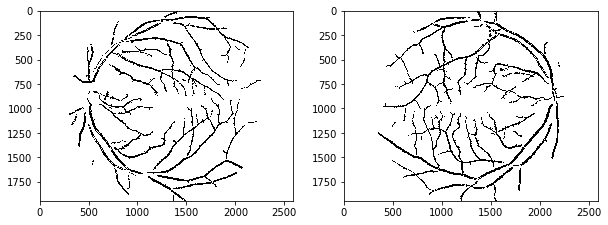

In [486]:
img_negative_left_bvc = segment_blood_vessel_channel(img_negative_left)
img_negative_right_bvc = segment_blood_vessel_channel(img_negative_right)
display_side_by_side(img_negative_left_bvc,img_negative_right_bvc)

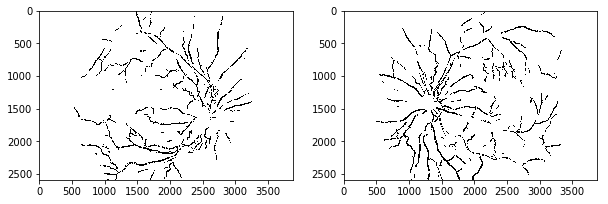

In [487]:
img_positive_left_bvc = segment_blood_vessel_channel(img_positive_left)
img_positive_right_bvc = segment_blood_vessel_channel(img_positive_right)
display_side_by_side(img_positive_left_bvc,img_positive_right_bvc)

#### Microaneurysm Segmentation

Microaneurysms are the earliest clinically visible changes of diabetic retinopathy. They are localised capillary dilatations which are usually saccular (round).

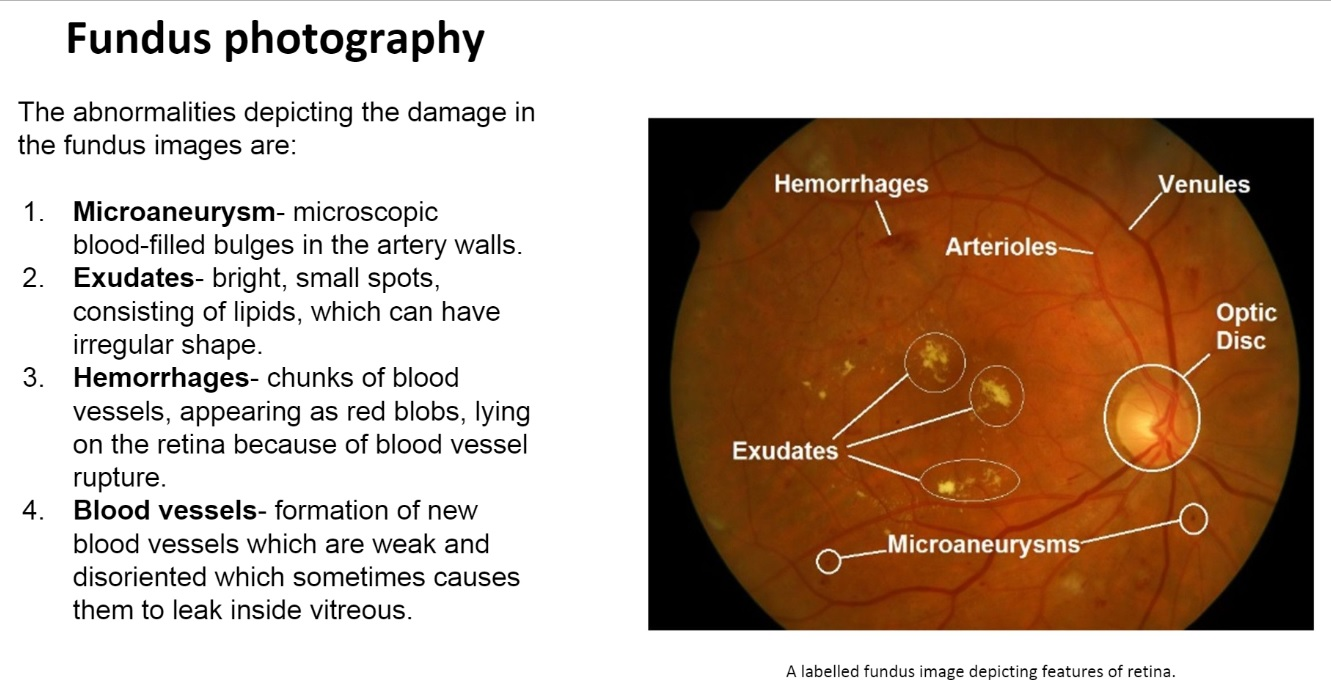

In [491]:
from IPython.display import Image
from IPython.core.display import HTML 
Image("RetinaComponents.jpg", width=600,height=600)

In [600]:
def find_microaneurysm(img,params):
    # Apply Canny Edge Detection and perform morph operations to find blobs
    img_cny = cv2.Canny(img,70,255)
    kernel = np.ones((5,5),np.uint8)
    img_cny = cv2.dilate(img_cny,kernel,iterations = 3)
    img_cny = cv2.erode(img_cny,kernel,iterations=4)
    #Initialize the blob detector
    ver = (cv2.__version__).split('.')
    if int(ver[0]) < 3 :
        detector = cv2.SimpleBlobDetector(params)
    else : 
        detector = cv2.SimpleBlobDetector_create(params)
    # Detect blobs.
    keypoints = detector.detect(img_cny)
    # Draw detected blobs as red circles.
    # cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures the size of the circle corresponds to the size of blob
    im_with_keypoints = cv2.drawKeypoints(img, keypoints, np.array([]), (0,255,0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    return im_with_keypoints    

In [605]:
params = cv2.SimpleBlobDetector_Params()

# Change thresholds
params.minThreshold = 0;
params.maxThreshold = 60;
 
# Filter by Area.
params.filterByArea = True
params.minArea = 10
 
# Filter by Circularity
params.filterByCircularity = True
params.minCircularity = 0.2
 
# Filter by Convexity
params.filterByConvexity = True
params.minConvexity = 0.60
 
# Filter by Inertia
params.filterByInertia = True
params.minInertiaRatio = 0.01

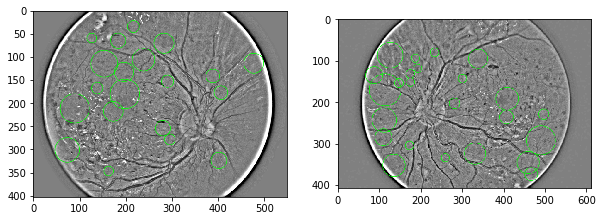

In [609]:
img_positive_left_mn = find_microaneurysm(img_positive_left_cropped,params)
img_positive_right_mn = find_microaneurysm(img_positive_right_cropped,params)
display_side_by_side(img_positive_left_mn,img_positive_right_mn)

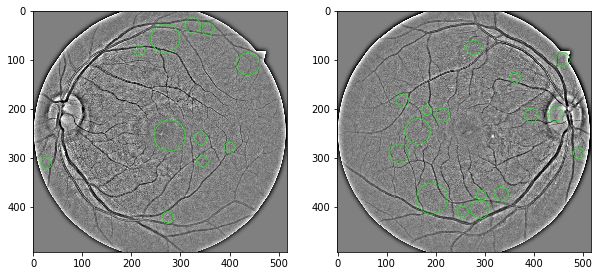

In [610]:
img_negative_left_mn = find_microaneurysm(img_negative_left_cropped,params)
img_negative_right_mn = find_microaneurysm(img_negative_right_cropped,params)
display_side_by_side(img_negative_left_mn,img_negative_right_mn)

**Steps Taken**
1. We first apply Canny Edge filtering to detect edge
2. Then a series of morphological opertions is applied for the noise removal. This removes the unnecessary structure with only blobs (contigous blocks of pixels with same intensity getting preserved)
3. Then we find the blobs by using Simple Blob Detector. The parameters of the blob detection can be configured and tweaked as per the feature of the image being detected (like area,minThreshold etc)
4. One difficulty we faced due to which the detected microaneurysm are not accurate is inability to loop over the blob detected and apply selective filtering after detection (Need to check and work on same)